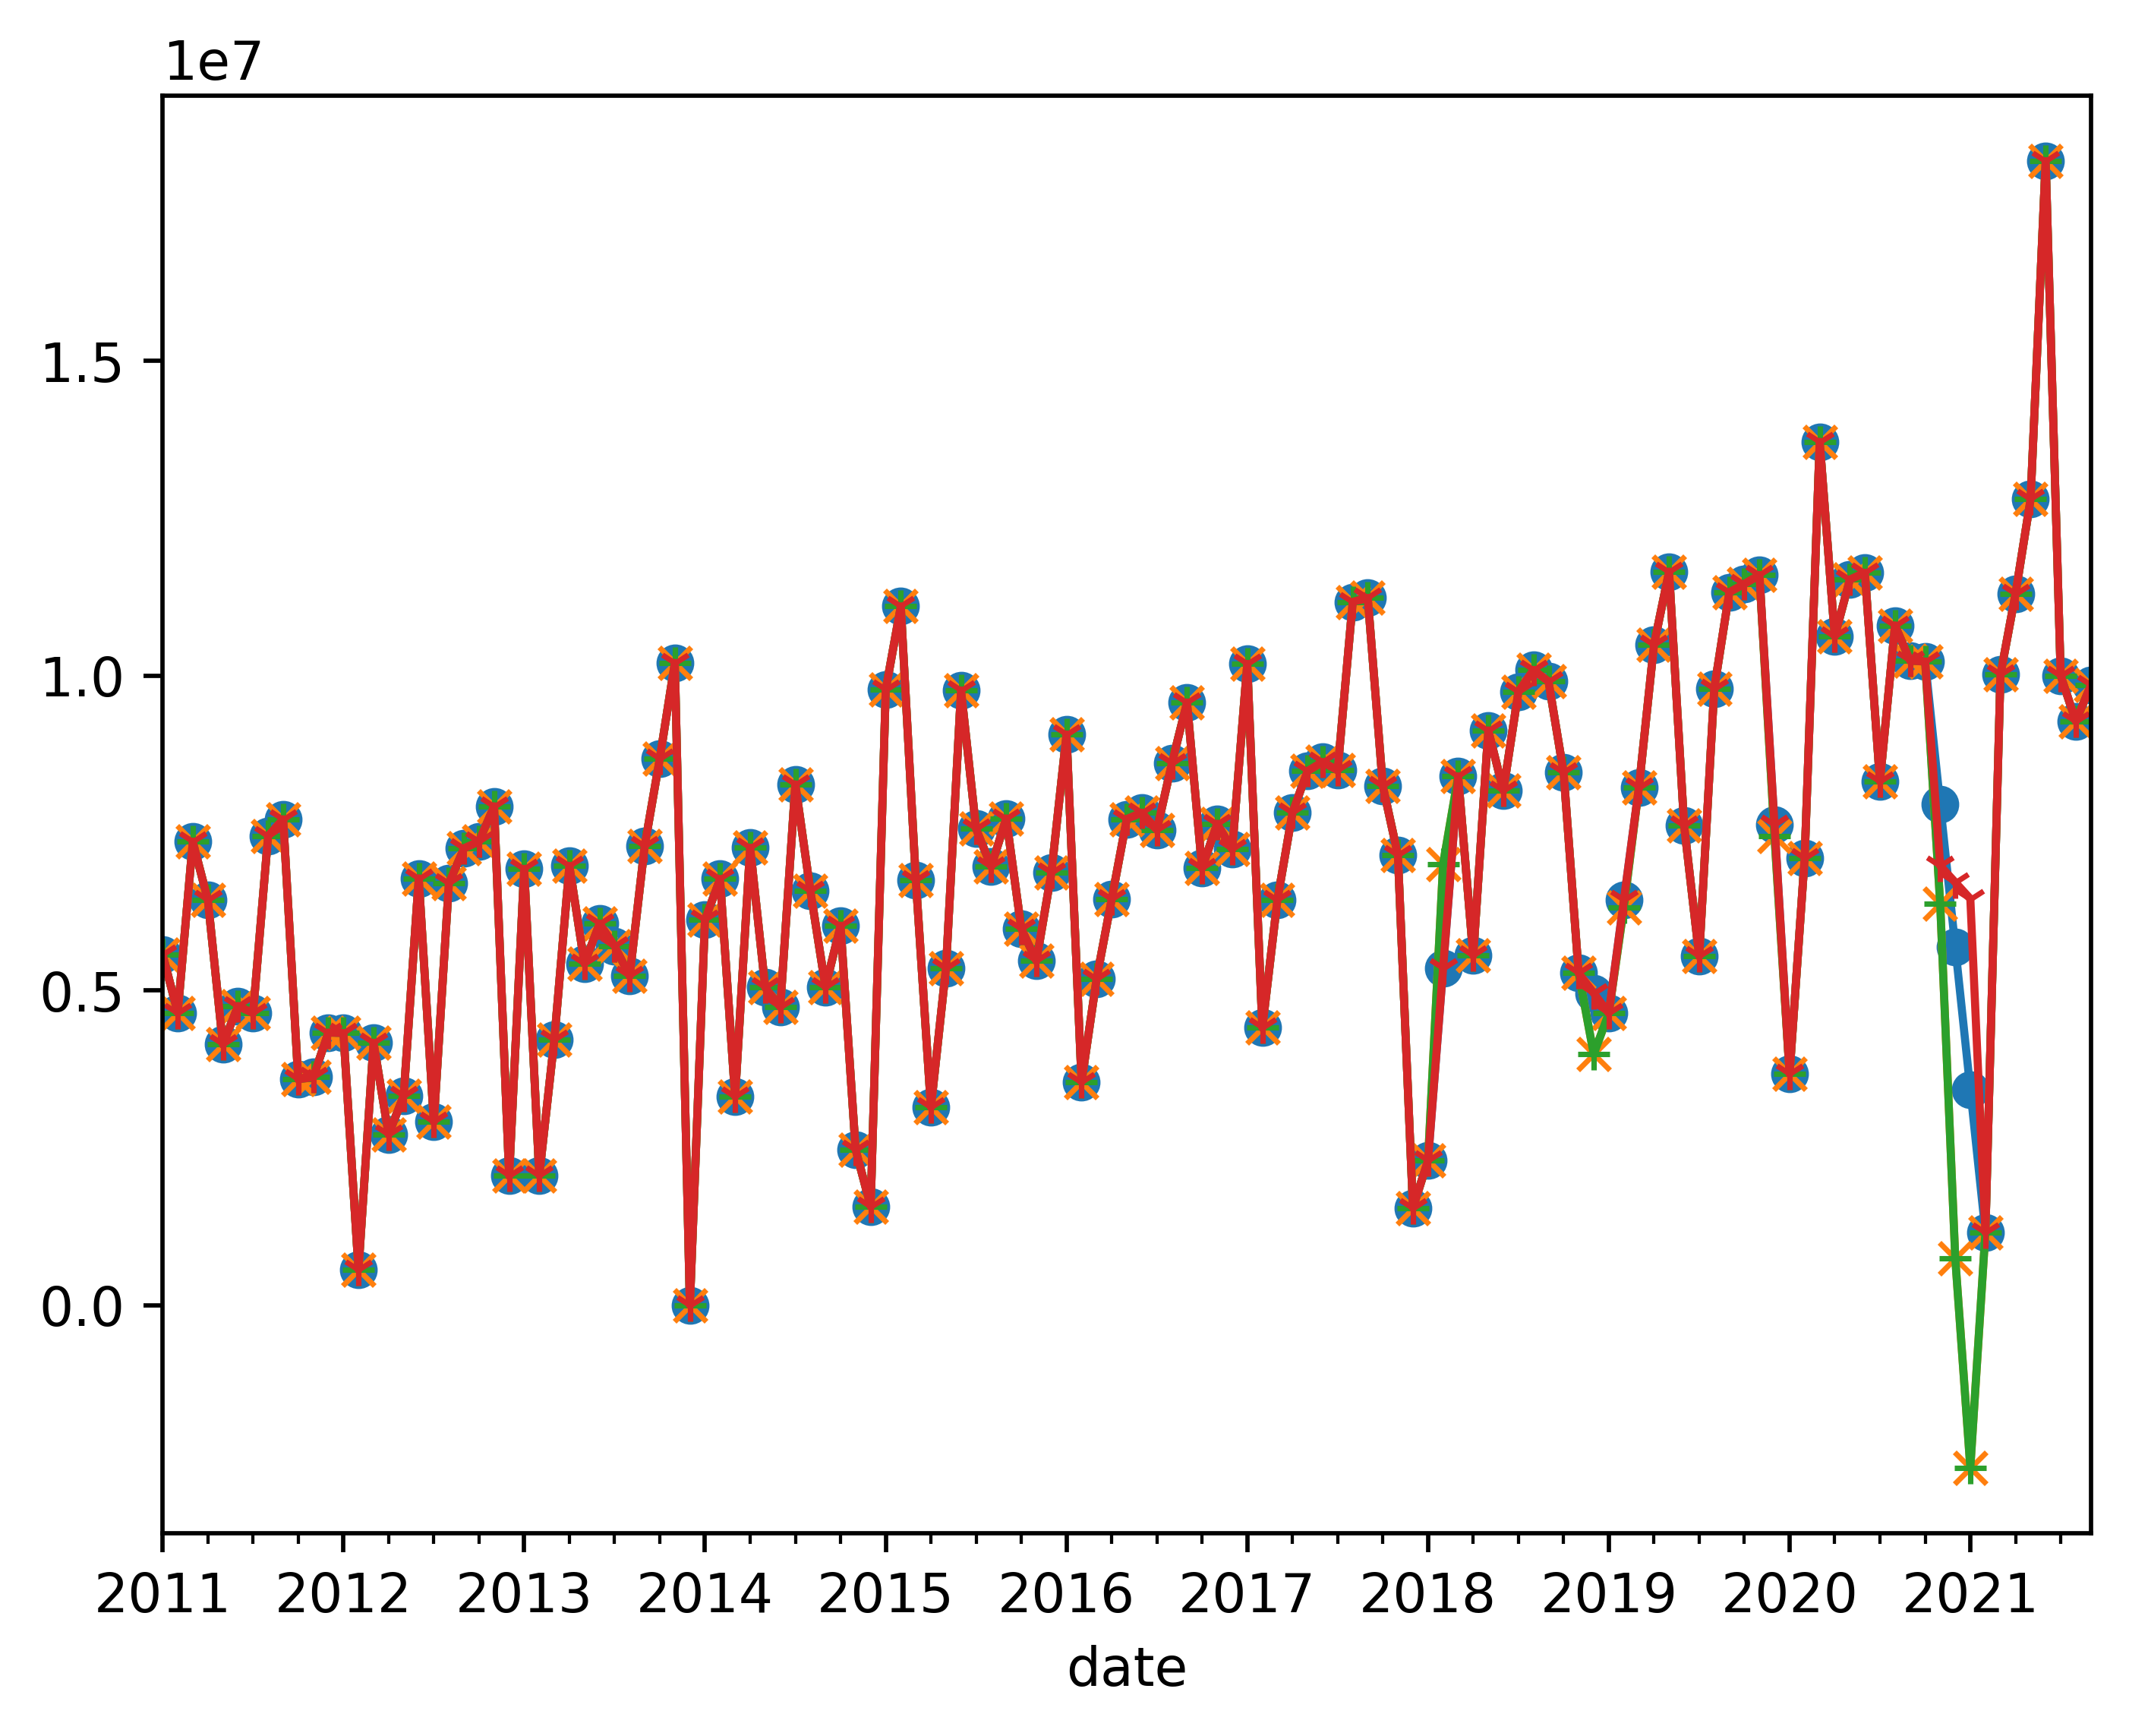

In [32]:
### 查看各插值方法对数据的影响

import numpy as np 
import pandas as pd
import warnings
from matplotlib import pyplot as plt 
warnings.filterwarnings("ignore")
plt.figure(dpi=512)
def my_plot(index,data,marker='o'):
    data.index  = index
    data.plot(marker=marker)

file_path = './source_data/A4.xlsx'
data = pd.read_excel(file_path)
data.columns = ['date1','id1','id2','values','sales']
data['date']=pd.to_datetime(data['date1'],format="%Y%m")
data.set_index(data['date'],inplace=True)
data = data[data['id1']>=0]
data = data[:-1] #去掉一个孤立的23年节点

data_linear = data['sales'].interpolate()
my_plot(data['date'],data_linear)
poly_data = data['sales'].interpolate(method='polynomial',order=3)
my_plot(data['date'],poly_data,'x')

spline_data = data['sales'].interpolate(method='spline',order=3)

my_plot(data['date'],spline_data,'+')

human_data = pd.read_excel('./source_data/A4backup.xlsx')
human_data.columns= ['date1','id1','id2','values','sales']
human_data = human_data[human_data['id1']>=0]
human_data = human_data[:-1]

my_plot(data['date'],human_data['sales'],'1')



In [33]:
human_data['sales'].to_excel('./temp.xlsx')

<AxesSubplot:xlabel='date'>

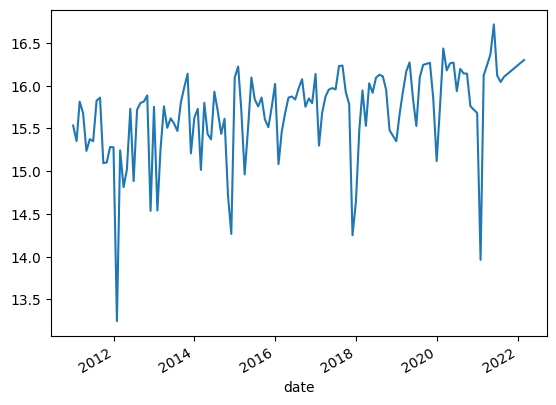

In [37]:
file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)

# data['sales'].plot()
data['sales'].plot()

# def difference(data_set,interval=1):
#     diff=list()
#     for i in range(interval,len(data_set)):
#         value=data_set[i]-data_set[i-interval]
#         diff.append(value)
#     return pd.Series(diff)

# diff_data = difference(data['sales'].values,1)
# diff_data = pd.DataFrame(diff_data)
# diff_data.index = data.index[1:]

# diff_data[0].plot()

[0]	validation_0-rmse:0.58504	validation_1-rmse:0.53864
[1]	validation_0-rmse:0.55030	validation_1-rmse:0.53714
[2]	validation_0-rmse:0.51595	validation_1-rmse:0.53894
[3]	validation_0-rmse:0.48572	validation_1-rmse:0.54020
[4]	validation_0-rmse:0.45864	validation_1-rmse:0.54327
[5]	validation_0-rmse:0.43250	validation_1-rmse:0.54787
[6]	validation_0-rmse:0.40906	validation_1-rmse:0.55477
[7]	validation_0-rmse:0.38607	validation_1-rmse:0.55976
[8]	validation_0-rmse:0.36365	validation_1-rmse:0.56643
[9]	validation_0-rmse:0.34266	validation_1-rmse:0.57271
[10]	validation_0-rmse:0.32351	validation_1-rmse:0.57820
[11]	validation_0-rmse:0.30494	validation_1-rmse:0.58482
[12]	validation_0-rmse:0.28820	validation_1-rmse:0.59236
[13]	validation_0-rmse:0.27249	validation_1-rmse:0.59819
[14]	validation_0-rmse:0.25851	validation_1-rmse:0.60301
[15]	validation_0-rmse:0.24585	validation_1-rmse:0.60708
[16]	validation_0-rmse:0.23279	validation_1-rmse:0.61205
[17]	validation_0-rmse:0.22060	validation

<AxesSubplot:>

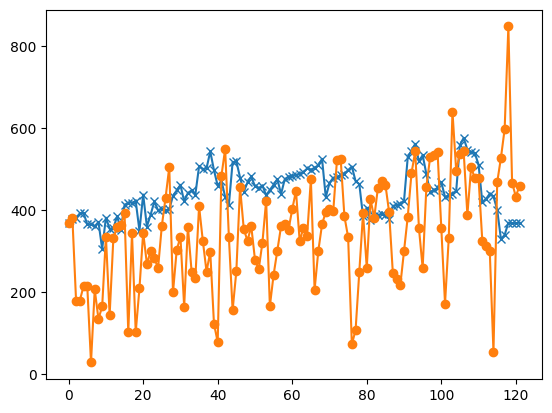

In [38]:
# use xgboost


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import xgboost as xgb

file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


def train_xgboost(data,in_windows,out_windows,train_num):
    X = []
    y = []
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= X[:train_num],y[:train_num],X[train_num:],y[train_num:]
    model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.1,early_stopping_rounds=50)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])
    test_pred = model.predict(X_test).reshape(-1,out_windows)
    print(test_pred)
    print("xgb r2:",r2_score(y_test,test_pred))
    print("xgb mse:",mean_squared_error(y_test,test_pred))
    print("xgb mae:",mean_absolute_error(y_test,test_pred))
    train_pred = model.predict(X_train).reshape(-1,out_windows)
    res = []
    for i in train_pred :
        res.append(i[0])
    for i in test_pred :
        res.append(i[0])
    return res

def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)


in_window_size,out_window_size = 4,4
input_data = diff_data[0:]
data_predict = train_xgboost(input_data[0],in_window_size,out_window_size,train_num=80)

data_true = input_data[in_window_size+out_window_size-1:]


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0],data_true[0])
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mase:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')



19:56:27 - cmdstanpy - INFO - Chain [1] start processing
19:56:27 - cmdstanpy - INFO - Chain [1] done processing


-1.0957905955444405
19537859814297.062
3844672.209841138


<AxesSubplot:>

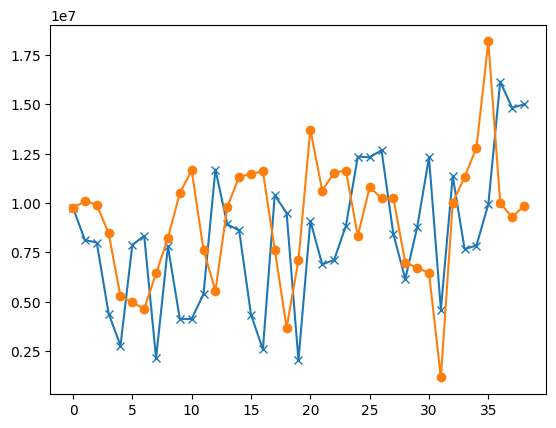

In [41]:
## train Prophet 


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

# diff_data[0].plot()

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

train_num = 90
# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']

train_data['ds'] = train_data.index
train_data = train_data[['ds','y']]

model = Prophet()
model.fit(train_data[0:])
future_times = model.make_future_dataframe(test_data.shape[0],freq='M',include_history=False)

test_predict = model.predict(future_times).yhat

# test_predict.index = test_data.index
# # test_predict = scaler.inverse_transform(test_predict).reshape(-1)
# # test_data = scaler.inverse_transform(test_data).reshape(-1)
# # train_data = scaler.inverse_transform(train_data)
# # test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)
inverse_predict = inverse_predict.apply(np.expm1)
# # # # inverse_predict



inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data.y)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')


-0.5419868352816777
109731.56667730119
264.1416811880416


<AxesSubplot:>

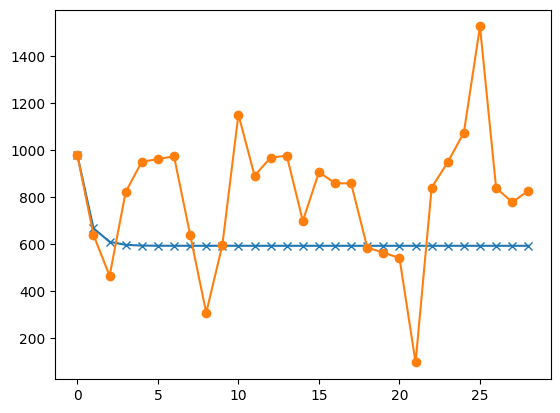

In [44]:
# auto_arima

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]



def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

train_num = 100
# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']



start_num = 0

model = auto_arima(train_data[start_num:], seasonal=True, m=24)
test_predict = model.predict(test_data.shape[0])

test_predict.index = test_data.index

# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# # # inverse_predict



inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data.y)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')

In [2]:
# test
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]

data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled


# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data = diff_data

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:-1]
train_data.columns =['y']





model = auto_arima(train_data[70:], seasonal=True, m=24)
test_predict = model.predict(30)



# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# print("train_end_date date:%s"%train_data.index[-1])
# print(inverse_predict)
datetime_series = pd.Series(pd.date_range(train_data.index[-1], periods=31, freq="m"))
inverse_predict['date'] = datetime_series
print(inverse_predict)

/Users/baigeiguai/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


               0       date
0   9.847283e+06 2021-08-31
1   9.345493e+06 2021-09-30
2   9.170473e+06 2021-10-31
3   8.153637e+06 2021-11-30
4   6.637973e+06 2021-12-31
5   7.987602e+06 2022-01-31
6   9.613011e+06 2022-02-28
7   8.946747e+06 2022-03-31
8   9.154543e+06 2022-04-30
9   9.178502e+06 2022-05-31
10  8.353422e+06 2022-06-30
11  8.988023e+06 2022-07-31
12  8.854303e+06 2022-08-31
13  8.851100e+06 2022-09-30
14  7.949936e+06 2022-10-31
15  7.864777e+06 2022-11-30
16  7.777168e+06 2022-12-31
17  4.798056e+06 2023-01-31
18  8.799861e+06 2023-02-28
19  9.103794e+06 2023-03-31
20  9.429089e+06 2023-04-30
21  1.040474e+07 2023-05-31
22  8.796065e+06 2023-06-30
23  8.611550e+06 2023-07-31
24  8.757810e+06 2023-08-31
25  8.629959e+06 2023-09-30
26  8.584205e+06 2023-10-31
27  8.305171e+06 2023-11-30
28  7.838533e+06 2023-12-31
29  8.257265e+06 2024-01-31
30  8.698717e+06 2024-02-29


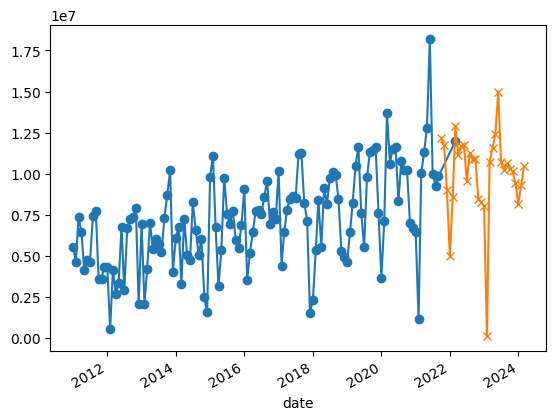

In [3]:
file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data.set_index(raw_data['date'],inplace=True)
raw_data['sales'][:-12].plot(marker='o')

inverse_predict.set_index(inverse_predict['date'],inplace=True)
ma = inverse_predict[0].max()
mi = inverse_predict[0].min()
nmi = 120000
nma = 1.5e7
((inverse_predict[0]-mi)/(ma-mi)*(nma-nmi)+nmi)[1:].plot(marker='x')
((inverse_predict[0]-mi)/(ma-mi)*(nma-nmi)+nmi)[1:].to_excel('./temp.xlsx')

# (inverse_predict[0]).to_excel('./temp.xlsx')

epoch_0:tensor(0.4574, grad_fn=<MseLossBackward0>)
epoch_1:tensor(0.3259, grad_fn=<MseLossBackward0>)
epoch_2:tensor(0.2281, grad_fn=<MseLossBackward0>)
epoch_3:tensor(0.1773, grad_fn=<MseLossBackward0>)
epoch_4:tensor(0.2155, grad_fn=<MseLossBackward0>)
epoch_5:tensor(0.2111, grad_fn=<MseLossBackward0>)
epoch_6:tensor(0.1902, grad_fn=<MseLossBackward0>)
epoch_7:tensor(0.1771, grad_fn=<MseLossBackward0>)
epoch_8:tensor(0.1734, grad_fn=<MseLossBackward0>)
epoch_9:tensor(0.1730, grad_fn=<MseLossBackward0>)
epoch_10:tensor(0.1732, grad_fn=<MseLossBackward0>)
epoch_11:tensor(0.1733, grad_fn=<MseLossBackward0>)
epoch_12:tensor(0.1732, grad_fn=<MseLossBackward0>)
epoch_13:tensor(0.1729, grad_fn=<MseLossBackward0>)
epoch_14:tensor(0.1728, grad_fn=<MseLossBackward0>)
epoch_15:tensor(0.1729, grad_fn=<MseLossBackward0>)
epoch_16:tensor(0.1730, grad_fn=<MseLossBackward0>)
epoch_17:tensor(0.1730, grad_fn=<MseLossBackward0>)
epoch_18:tensor(0.1728, grad_fn=<MseLossBackward0>)
epoch_19:tensor(0.1727

<AxesSubplot:>

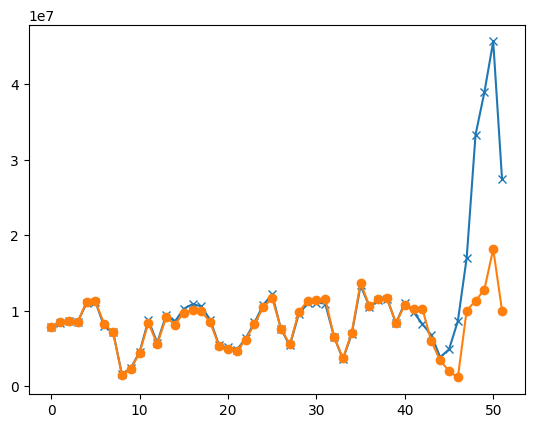

In [90]:
# use lstm


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from prophet import Prophet
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import xgboost as xgb
import torch

file_path = './source_data/A4.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='linear')



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


class lstm(torch.nn.Module):
    def __init__(self,in_windows,out_windows, hidden_size, hidden_num_layers):
        super(lstm, self).__init__()
        # 定义LSTM
        self.lstm = torch.nn.LSTM(1, hidden_size, hidden_num_layers)
        # 定义回归层网络，输入的特征维度等于LSTM的输出，输出维度为1
        self.reg = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 25),
            torch.nn.Sigmoid(),
            torch.nn.Linear(25, out_windows),
        )

    def forward(self,x):
        x = x.transpose(-1,-2)
        x = x.view(x.shape[0],x.shape[1],1)
        x,(h,c)= self.lstm(x)
        return self.reg(h[-1])
    

def train_lstm(data,in_windows,out_windows,train_num,epoch_num):
    X = [] 
    y = [] 
    L = len(data)
    for i in range(L):
        if i+in_windows+out_windows > L:
            break
        X.append(data[i:i+in_windows])
        y.append(data[i+in_windows:i+in_windows+out_windows])
    X = np.array(X)
    y = np.array(y)
    X_train,y_train,X_test,y_test= torch.tensor(X[:train_num]).type(torch.float32),torch.tensor(y[:train_num]).type(torch.float32),torch.tensor(X[train_num:]).type(torch.float32),torch.tensor(y[train_num:],requires_grad=False).type(torch.float32)
    # print("XXXX",X_test.shape)
    model = lstm(in_windows=in_windows,out_windows=out_windows,hidden_size=60,hidden_num_layers=4)
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)
    lossfn = torch.nn.MSELoss()
    for epoch_idx in range(epoch_num):
        optimizer.zero_grad()
        out = model(X_train)
        error = lossfn(out,y_train)
        print("epoch_%d:%s"%(epoch_idx,error))
        error.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        test_pred = model(X_test)
        print("lstm r2:",r2_score(y_test,test_pred))
        print("lstm mse:",mean_squared_error(y_test,test_pred))
        print("lstm mae:",mean_absolute_error(y_test,test_pred))
        train_pred = model(X_train)
        res = []
        for i in train_pred.numpy() :
            res.append(i[0])
        for i in test_pred.numpy():
            res.append(i[0])
        return res


def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)


in_window_size,out_window_size = 5,3
train_start = 70
input_data = diff_data[train_start:]
input_data.columns = ['y']
data_predict = train_lstm(input_data.y.values,in_window_size,out_window_size,train_num=40,epoch_num=130)
data_true = input_data[in_window_size:]
if out_window_size!= 1 :
    data_true = data_true[:-out_window_size+1]

# data_true.y.plot()
# data_predict = pd.DataFrame(data_predict)
# data_predict.index = data_true.index
# data_predict[0].plot()
# print(data_predict.shape)


inverse_predict =  inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_predict)
inverse_predict = inverse_predict.apply(np.expm1)

inverse_true  = inverse_difference(input_data[:in_window_size].sum().values[0]+data['sales'][0]+diff_data[:train_start][0].sum(),data_true.y)
inverse_true = inverse_true.apply(np.expm1)

print("raw r2:",r2_score(inverse_true[0],inverse_predict[0]))
print("raw mse:",mean_squared_error(inverse_true[0],inverse_predict[0]))
print("raw mae:",mean_absolute_error(inverse_true[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_true[0].plot(marker='o')



In [89]:
inverse_predict[0].to_excel('./temp.xlsx')

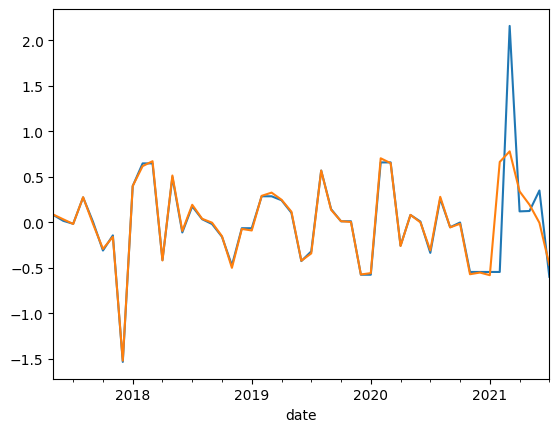

In [88]:
data_true.y.plot()
ndata_predict = pd.DataFrame(data_predict)
ndata_predict.index = data_true.index
ndata_predict[0].plot()
ndata_predict.to_excel('./temp.xlsx')
# ndata_predict[0].to_excel('temp.xlsx')
# print(inverse_true)
# print(inverse_predict.values)

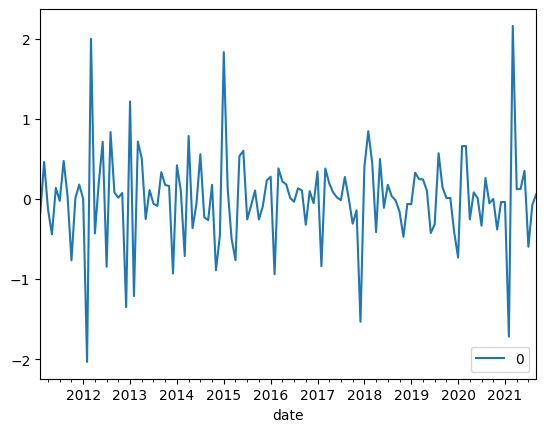

In [79]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]

data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

diff_data.plot()
diff_data.to_excel('./temp.xlsx')

<AxesSubplot:>

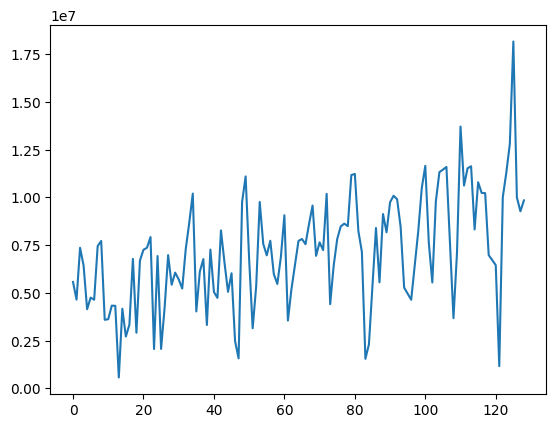

In [58]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A4backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','values','sales']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
raw_data = raw_data[:-1]

data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)
raw_data['sales'].plot()